In [2]:
# import TensorFlow as TF
import pandas as pd
import math
import matplotlib.pylab as plt
import numpy as np

from datetime import datetime

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer # used for handling missing data
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error


In [3]:

df = pd.read_csv('data.csv')
data_top = df.head()
copy = df.copy() 

# 1 - Remove rows where the target column (Scope1) is NaN.

copy = copy[copy['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1'].notna()] # drop all rows with NaN in target column

copy = copy.reset_index() 



# 2 - Replace all NaN from the attribute columns and replace for mean of that column

#copy = copy.fillna(copy.mean())
#col_names = copy.columns
#sub2[col_names].fillna((sub2[col_names].mean()), inplace=True)

# 3 - Group rows by organization ID

# org_ids = list(copy['GTAP country'])
# list_set = set(org_ids)
# unique = list(list_set)

# copy = copy.groupby(['GTAP country'])

# dictionary = {} 

# for item in unique:
#     df_id = copy.get_group(item)
#     dictionary[item] = df_id


def create_dict(target_var, df): 
    org_ids = list(df[target_var]) 
    list_set = set(org_ids) # get unique elements
    unique = list(list_set) # place them in a list 

    df = df.groupby([target_var]) 

    dictionary = {} 

    for item in unique:
        df_id = df.get_group(item)
        dictionary[item] = df_id
    
    return dictionary
    

# dictionaries per target variable:

GTAP_sector_dict = create_dict('GTAP sector', copy)

GTAP_country_dict = create_dict('GTAP country', copy)



key_list = list(GTAP_sector_dict.keys())

print(key_list)

#print(GTAP_sector_dict)

# in the dictionary, we want to replace all the NaN of the values for the means of those columns.


# # check missing values >> columns with lots of missing values are not useful. 
# missing_values_df = copy.isnull().sum().sort_values(ascending=False).head()
# print(missing_values_df)

# # replace NaN in column for mean of column with Imputer 
# imp = SimpleImputer(missing_values='NaN', strategy='mean')
# imp = imp.fit(copy)



#print(replace_NaN(GTAP_sector_dict))    



['Crops nec', 'Transport nec', 'Air transport', 'Wheat', 'Water transport', 'Forestry', 'Recreational and other services', 'Food products nec', 'Sugar cane, sugar beet', 'Oil', 'Motor vehicles and parts', 'Electrical equipment', 'Accommodation, Food and service activities', 'Business services nec', 'Vegetables, fruit, nuts', 'Gas', 'Basic pharmaceutical products', 'Machinery and equipment nec', 'Human health and social work activities', 'Transport equipment nec', 'Chemical products', 'Warehousing and support activities', 'Textiles', 'Bovine cattle, sheep and goats, horses', 'Wood products', 'None', 'Ferrous metals', 'Beverages and tobacco products', 'Paper products, publishing', 'Manufactures nec', 'Metals nec', 'Communication', 'Coal', 'Computer, electronic and optical products', 'Fishing', 'Financial services nec', 'Animal products nec', 'Insurance', 'Metal products', 'Education', 'Processed rice', 'Null', 'Wearing apparel', 'Petroleum, coal products', 'Real estate activities', 'Othe

In [4]:
# function for filling NaN's (with mean of column)
def fill_nan(df, column_name):
    mean_value=df[column_name].mean()
    df[column_name].fillna(value=mean_value, inplace=True)
    return df



In [5]:
# copy.groupby("organization_id")['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1'].plot(x='StatementDetails.FinancialPeriodFiscalYear',y='EmissionDataPoints.CO2EquivalentsEmissionDirectScope1')
# .mean()


# org_dict = create_dict('organization_id', copy)



# print(list(GTAP_country_dict))
# print(org_dict.type)
# print(list(copy.columns.values))



In [6]:
# regr = linear_model.LinearRegression()
# regr.fit(diabetes_X_train, diabetes_y_train)
# diabetes_y_pred = regr.predict(diabetes_X_test)

# polynomial regression 

dict_id = create_dict('GTAP sector', copy)
air = dict_id['Air transport']
# print(air)
Y = air['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1']
X = air.loc[:, ['StatementDetails.FinancialPeriodFiscalYear', 'EmissionIndicators.TotalCO2EquivalentsEmissionsToRevenues', 'EmissionIndicators.NOxEmissionsToRevenues']]


# filling missing values with mean 
X = fill_nan(X, 'EmissionIndicators.TotalCO2EquivalentsEmissionsToRevenues')
X = fill_nan(X, 'EmissionIndicators.NOxEmissionsToRevenues')
print(X)
X = np.array(X)
# X = X.reshape(-1,1) # alleen voor 1 input variable
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.33, random_state=42)
degree = 5
polyreg=make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg.fit(X_train,Y_train)
predictions = polyreg.predict(X_test)

# print("Coefficients: \n", polyreg.coef_)
# The mean squared error
print("Mean absolute error: %.2f" % mean_absolute_error(Y_test, predictions))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_test, predictions))

print(Y.mean())


       StatementDetails.FinancialPeriodFiscalYear  \
198                                          2013   
336                                          2011   
427                                          2014   
455                                          2017   
488                                          2009   
...                                           ...   
24678                                        2015   
24679                                        2010   
24770                                        2019   
24935                                        2012   
25028                                        2014   

       EmissionIndicators.TotalCO2EquivalentsEmissionsToRevenues  \
198                                           860.007572           
336                                          1155.559121           
427                                          1187.299487           
455                                           867.054573           
488                    

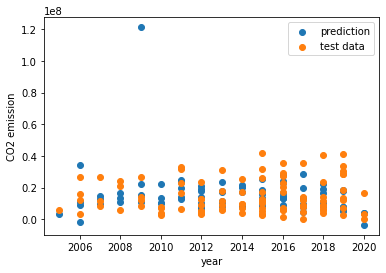

In [7]:
plt.scatter(X_test[:, 0], predictions, label='prediction')
plt.scatter(X_test[:, 0], Y_test, label='test data')

plt.xlabel("year")
plt.ylabel("CO2 emission")
plt.legend()
plt.show()

/Users/isabellemos/miniforge3/envs/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


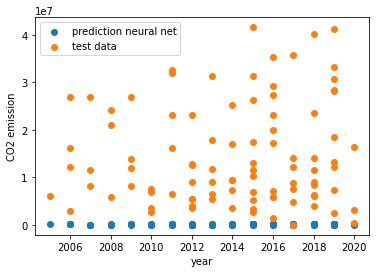

In [8]:
# neural networks

regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, Y_train)
pred_nn = regr.predict(X_test)
regr.score(X_test, Y_test)

plt.scatter(X_test[:, 0], pred_nn, label='prediction neural net')
plt.scatter(X_test[:, 0], Y_test, label='test data')

plt.xlabel("year")
plt.ylabel("CO2 emission")
plt.legend()
plt.show()



Mean absolute error: 10658660.44
Coefficient of determination: -0.49


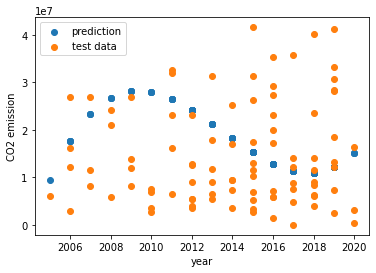

In [9]:
# making future predictions


X = air.loc[:, ['StatementDetails.FinancialPeriodFiscalYear']]

X = np.array(X)
# X = X.reshape(-1,1) # alleen voor 1 input variable
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.33, random_state=42)
degree = 4
polyreg=make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg.fit(X_train,Y_train)
predictions = polyreg.predict(X_test)
print("Mean absolute error: %.2f" % mean_absolute_error(Y_test, predictions))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_test, predictions))

plt.scatter(X_test[:, 0], predictions, label='prediction')
plt.scatter(X_test[:, 0], Y_test, label='test data')

plt.xlabel("year")
plt.ylabel("CO2 emission")
plt.legend()
plt.show()

In [10]:
print(len(X_test))
print(X_test)

X_test[30][0] = 2021
    
print(X_test)

94
[[2010]
 [2018]
 [2016]
 [2016]
 [2017]
 [2011]
 [2015]
 [2007]
 [2012]
 [2008]
 [2015]
 [2018]
 [2020]
 [2018]
 [2011]
 [2015]
 [2014]
 [2012]
 [2015]
 [2006]
 [2019]
 [2016]
 [2013]
 [2016]
 [2010]
 [2012]
 [2016]
 [2009]
 [2015]
 [2016]
 [2019]
 [2020]
 [2017]
 [2016]
 [2018]
 [2015]
 [2016]
 [2017]
 [2018]
 [2015]
 [2006]
 [2019]
 [2018]
 [2010]
 [2012]
 [2016]
 [2011]
 [2011]
 [2017]
 [2009]
 [2017]
 [2005]
 [2012]
 [2008]
 [2013]
 [2019]
 [2012]
 [2014]
 [2015]
 [2006]
 [2014]
 [2018]
 [2017]
 [2009]
 [2019]
 [2014]
 [2007]
 [2019]
 [2018]
 [2012]
 [2010]
 [2019]
 [2014]
 [2009]
 [2015]
 [2014]
 [2019]
 [2017]
 [2006]
 [2007]
 [2011]
 [2013]
 [2013]
 [2016]
 [2015]
 [2019]
 [2019]
 [2015]
 [2008]
 [2018]
 [2020]
 [2013]
 [2013]
 [2012]]
[[2010]
 [2018]
 [2016]
 [2016]
 [2017]
 [2011]
 [2015]
 [2007]
 [2012]
 [2008]
 [2015]
 [2018]
 [2020]
 [2018]
 [2011]
 [2015]
 [2014]
 [2012]
 [2015]
 [2006]
 [2019]
 [2016]
 [2013]
 [2016]
 [2010]
 [2012]
 [2016]
 [2009]
 [2015]
 [2016]
 [20

In [11]:
predictions = polyreg.predict(X_test)

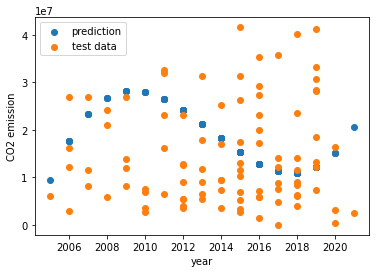

In [12]:
plt.scatter(X_test[:, 0], predictions, label='prediction')
plt.scatter(X_test[:, 0], Y_test, label='test data')

plt.xlabel("year")
plt.ylabel("CO2 emission")
plt.legend()
plt.show()

In [19]:
#air['StatementDetails.FinancialPeriodEndDate'] = air['StatementDetails.FinancialPeriodEndDate'].map(lambda x: x.rstrip('T00:00:00.000Z'))
#air['StatementDetails.FinancialPeriodEndDate'] = air['StatementDetails.FinancialPeriodEndDate'].map(lambda x: x.replace('-', '/'))
#air['StatementDetails.FinancialPeriodEndDate'] = air['StatementDetails.FinancialPeriodEndDate'].map(lambda x: datetime.strptime(x, '%Y/%m/%d'))

air['StatementDetails.FinancialPeriodEndDate'] = pd.to_datetime(air['StatementDetails.FinancialPeriodEndDate'])

air['StatementDetails.FinancialPeriodEndDate'] = air['StatementDetails.FinancialPeriodEndDate'].dt.date

air = air.sort_values(by='StatementDetails.FinancialPeriodEndDate')

print(air['StatementDetails.FinancialPeriodEndDate'])





3718     2004-03-31
15088    2004-12-31
16929    2005-03-31
14565    2005-12-31
763      2005-12-31
            ...    
11947    2020-03-31
2952     2020-06-30
7875     2020-06-30
9108     2020-10-31
2089     2020-12-31
Name: StatementDetails.FinancialPeriodEndDate, Length: 284, dtype: object


In [14]:
X = air.loc[:, ['StatementDetails.FinancialPeriodEndDate']]
X = np.array(X)
# X = X.reshape(-1,1) # alleen voor 1 input variable
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.33, random_state=42)
degree = 1
polyreg=make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg.fit(X_train,Y_train)
predictions = polyreg.predict(X_test)
print("Mean absolute error: %.2f" % mean_absolute_error(Y_test, predictions))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_test, predictions))

plt.plot(X_test[:, 0], predictions, label='prediction')
plt.scatter(X_test[:, 0], Y_test, label='test data')

plt.xlabel("year")
plt.ylabel("CO2 emission")
plt.legend()
plt.show()



TypeError: float() argument must be a string or a real number, not 'datetime.date'